<a href="https://colab.research.google.com/github/Cheryleen5/Audio_deepfake_detection/blob/main/Honors1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
df = pd.read_csv("feature1.csv")

In [ ]:
df['label'].value_counts()
print(df['label'])

0      FAKE
1      FAKE
2      FAKE
3      FAKE
4      FAKE
       ... 
379    REAL
380    REAL
381    REAL
382    REAL
383    REAL
Name: label, Length: 384, dtype: object


In [ ]:
# Before SMOTE
print("Original class distribution:\n", pd.Series(y).value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# After SMOTE
print("After SMOTE class distribution:\n", pd.Series(y_resampled).value_counts())
print(f"Total samples after SMOTE: {len(y_resampled)}")


Original class distribution:
 0    336
1     48
Name: count, dtype: int64
After SMOTE class distribution:
 0    336
1    336
Name: count, dtype: int64
Total samples after SMOTE: 672


In [ ]:
# Drop NaN values from 'label' column
df = df.dropna(subset=["label"])
df["label"] = df["label"].map({"REAL": 1, "FAKE": 0}).astype(int)

In [ ]:
def build_model():
    model = Sequential([
        Input(shape=(13, 1)),  # MFCC Shape

        # 1st Convolutional Block
        Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # 2nd Convolutional Block
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # 3rd Convolutional Block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # BiLSTM Layer
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
        Bidirectional(LSTM(64, return_sequences=False, dropout=0.2)),

        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary Classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize Model
model = build_model()

In [ ]:
# Extract MFCC Features
mfcc_mean_columns = [f"mfcc_{i}_mean" for i in range(1, 14)]
X = df[mfcc_mean_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Extract MFCC Features
mfcc_mean_columns = [f"mfcc_{i}_mean" for i in range(1, 14)]
X = df[mfcc_mean_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape Data for Conv1D Input (Adding 3rd dimension)
X_train = X_train.reshape(-1, 13, 1)
X_test = X_test.reshape(-1, 13, 1)

# Train the Model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=4,
                    validation_split=0.2)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.5269 - loss: 0.6913 - val_accuracy: 0.5093 - val_loss: 0.6926
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7361 - loss: 0.6753 - val_accuracy: 0.5093 - val_loss: 0.6878
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7671 - loss: 0.6073 - val_accuracy: 0.6481 - val_loss: 0.6450
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8514 - loss: 0.4557 - val_accuracy: 0.7870 - val_loss: 0.4661
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8898 - loss: 0.2710 - val_accuracy: 0.8519 - val_loss: 0.2888
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9268 - loss: 0.1962 - val_accuracy: 0.9722 - val_loss: 0.1333
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9655 - loss: 0.1220 - val_accuracy: 0.9630 - val_loss: 0.0877
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9865 - loss: 0.0602 - val_acc

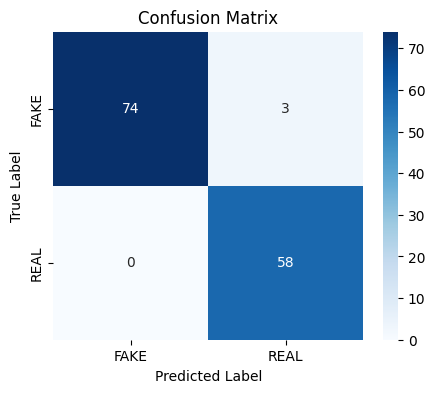

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        77
           1       0.95      1.00      0.97        58

    accuracy                           0.98       135
   macro avg       0.98      0.98      0.98       135
weighted avg       0.98      0.98      0.98       135



In [ ]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


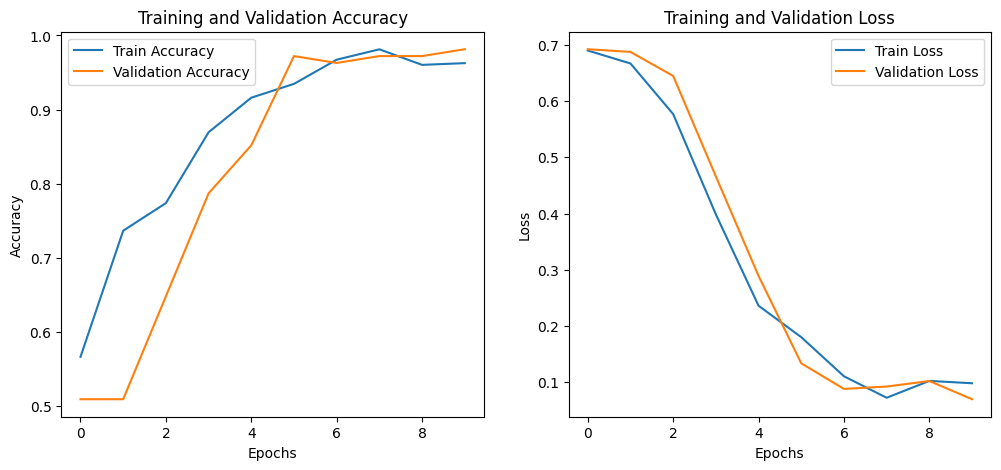

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Extract MFCC Features
delta_mfcc_mean_columns = [f"delta_mfcc_{i}_mean" for i in range(1, 14)]
X = df[delta_mfcc_mean_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape Data for Conv1D Input (Adding 3rd dimension)
X_train = X_train.reshape(-1, 13, 1)
X_test = X_test.reshape(-1, 13, 1)

# Train the Model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=4,
                    validation_split=0.2)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5179 - loss: 0.6921 - val_accuracy: 0.5278 - val_loss: 0.6925
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7340 - loss: 0.6777 - val_accuracy: 0.5463 - val_loss: 0.6851
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8177 - loss: 0.6078 - val_accuracy: 0.8889 - val_loss: 0.6035
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9114 - loss: 0.3938 - val_accuracy: 0.8981 - val_loss: 0.4078
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9139 - loss: 0.2748 - val_accuracy: 0.9537 - val_loss: 0.2393
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9360 - loss: 0.2122 - val_accuracy: 0.9074 - val_loss: 0.3268
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9601 - loss: 0.1232 - val_accuracy: 0.9167 - val_loss: 0.2297
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9470 - loss: 0.1781 - val_acc

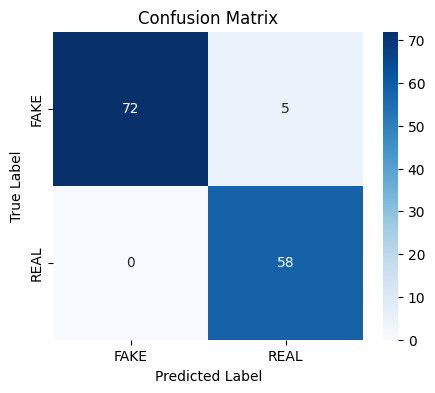

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        77
           1       0.92      1.00      0.96        58

    accuracy                           0.96       135
   macro avg       0.96      0.97      0.96       135
weighted avg       0.97      0.96      0.96       135



In [ ]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


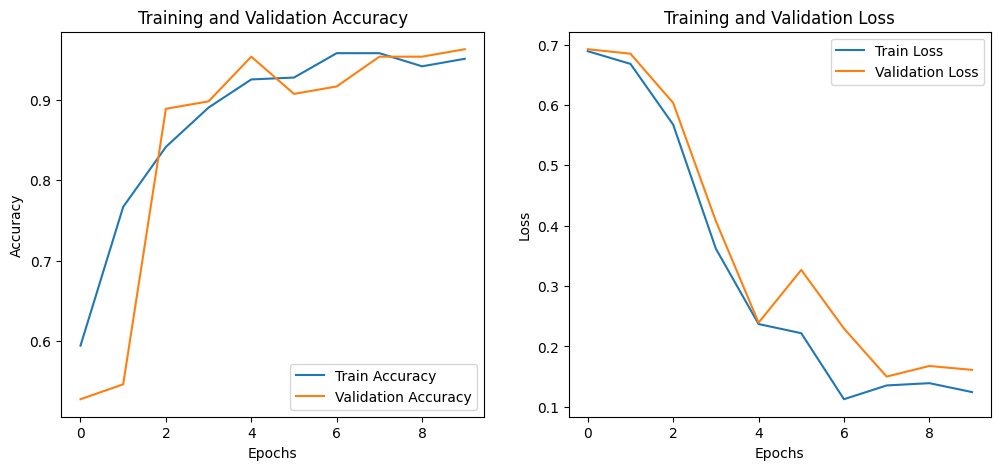

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Extract MFCC Features
double_delta_mfcc_mean_columns = [f"double_delta_mfcc_{i}_mean" for i in range(1, 14)]
X = df[double_delta_mfcc_mean_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape Data for Conv1D Input (Adding 3rd dimension)
X_train = X_train.reshape(-1, 13, 1)
X_test = X_test.reshape(-1, 13, 1)

# Train the Model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=4,
                    validation_split=0.2)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.4760 - loss: 0.6931 - val_accuracy: 0.4907 - val_loss: 0.6933
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6079 - loss: 0.6875 - val_accuracy: 0.5093 - val_loss: 0.6924
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6862 - loss: 0.6644 - val_accuracy: 0.5463 - val_loss: 0.6781
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8031 - loss: 0.5797 - val_accuracy: 0.7407 - val_loss: 0.5899
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8750 - loss: 0.4171 - val_accuracy: 0.8704 - val_loss: 0.4503
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8969 - loss: 0.2926 - val_accuracy: 0.9444 - val_loss: 0.2738
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9180 - loss: 0.2346 - val_accuracy: 0.9907 - val_loss: 0.1876
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8905 - loss: 0.2475 - val_acc

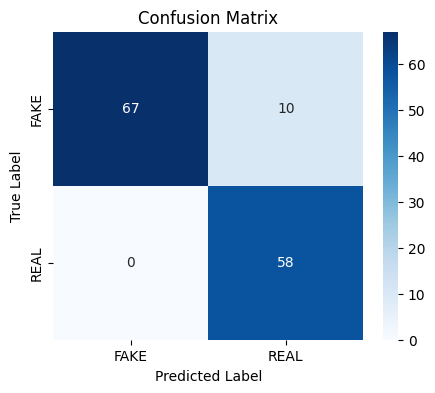

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        77
           1       0.85      1.00      0.92        58

    accuracy                           0.93       135
   macro avg       0.93      0.94      0.93       135
weighted avg       0.94      0.93      0.93       135



In [ ]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


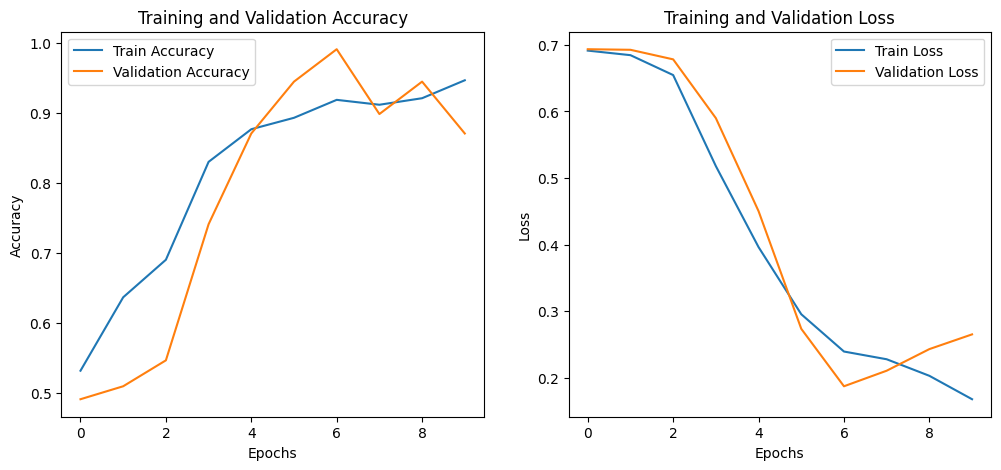

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Extract MFCC Features
mfcc_std_columns = [f"mfcc_{i}_std" for i in range(1, 14)]
X = df[mfcc_std_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape Data for Conv1D Input (Adding 3rd dimension)
X_train = X_train.reshape(-1, 13, 1)
X_test = X_test.reshape(-1, 13, 1)

# Train the Model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=4,
                    validation_split=0.2)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6803 - loss: 0.7769 - val_accuracy: 0.7963 - val_loss: 0.4087
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8916 - loss: 0.3267 - val_accuracy: 0.8981 - val_loss: 0.2581
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9176 - loss: 0.2139 - val_accuracy: 0.8981 - val_loss: 0.1890
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9444 - loss: 0.1432 - val_accuracy: 0.9074 - val_loss: 0.2190
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9720 - loss: 0.0991 - val_accuracy: 0.9167 - val_loss: 0.2772
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9733 - loss: 0.0912 - val_accuracy: 0.9167 - val_loss: 0.2145
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9805 - loss: 0.0830 - val_accuracy: 0.9259 - val_loss: 0.2926
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9754 - loss: 0.0778 - val_accu

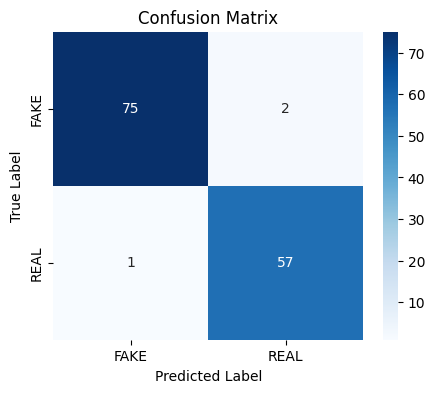

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        77
           1       0.97      0.98      0.97        58

    accuracy                           0.98       135
   macro avg       0.98      0.98      0.98       135
weighted avg       0.98      0.98      0.98       135



In [ ]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


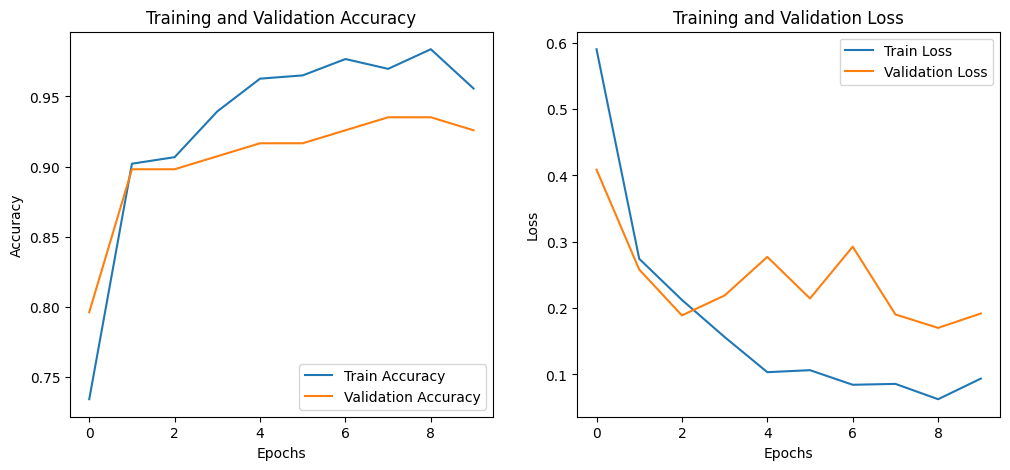

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Extract MFCC Features
delta_mfcc_std_columns = [f"delta_mfcc_{i}_std" for i in range(1, 14)]
X = df[delta_mfcc_std_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape Data for Conv1D Input (Adding 3rd dimension)
X_train = X_train.reshape(-1, 13, 1)
X_test = X_test.reshape(-1, 13, 1)

# Train the Model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=4,
                    validation_split=0.2)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5900 - loss: 0.6864 - val_accuracy: 0.6667 - val_loss: 0.6909
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6963 - loss: 0.6563 - val_accuracy: 0.7593 - val_loss: 0.6812
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8105 - loss: 0.5568 - val_accuracy: 0.8704 - val_loss: 0.6256
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9003 - loss: 0.3219 - val_accuracy: 0.9259 - val_loss: 0.3811
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9537 - loss: 0.1361 - val_accuracy: 0.9167 - val_loss: 0.2140
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9774 - loss: 0.0783 - val_accuracy: 0.9815 - val_loss: 0.0810
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9880 - loss: 0.0559 - val_accuracy: 0.9907 - val_loss: 0.0366
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9676 - loss: 0.0889 - val_acc

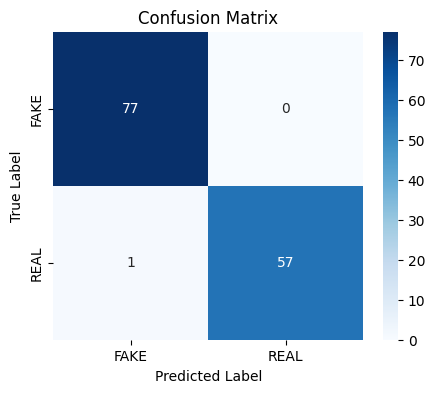

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      0.98      0.99        58

    accuracy                           0.99       135
   macro avg       0.99      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135



In [ ]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


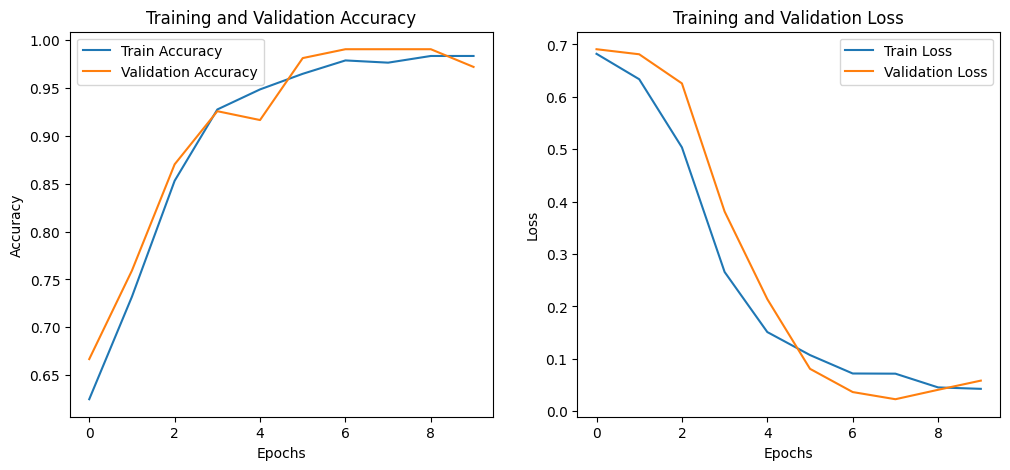

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Extract MFCC Features
double_delta_mfcc_std_columns = [f"double_delta_mfcc_{i}_std" for i in range(1, 14)]
X = df[double_delta_mfcc_std_columns].values
y = df["label"].values

# Normalize MFCC Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape Data for Conv1D Input (Adding 3rd dimension)
X_train = X_train.reshape(-1, 13, 1)
X_test = X_test.reshape(-1, 13, 1)

# Train the Model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=4,
                    validation_split=0.2)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5538 - loss: 0.6890 - val_accuracy: 0.7037 - val_loss: 0.6920
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7347 - loss: 0.6432 - val_accuracy: 0.7222 - val_loss: 0.6833
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9004 - loss: 0.5046 - val_accuracy: 0.8611 - val_loss: 0.6201
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9338 - loss: 0.2778 - val_accuracy: 0.9444 - val_loss: 0.4078
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9525 - loss: 0.1418 - val_accuracy: 0.8981 - val_loss: 0.2355
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9668 - loss: 0.0996 - val_accuracy: 1.0000 - val_loss: 0.0350
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9735 - loss: 0.0860 - val_accuracy: 1.0000 - val_loss: 0.0198
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9785 - loss: 0.0602 - val_acc

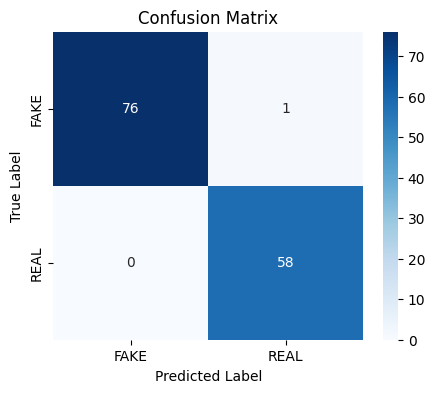

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        77
           1       0.98      1.00      0.99        58

    accuracy                           0.99       135
   macro avg       0.99      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135



In [ ]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


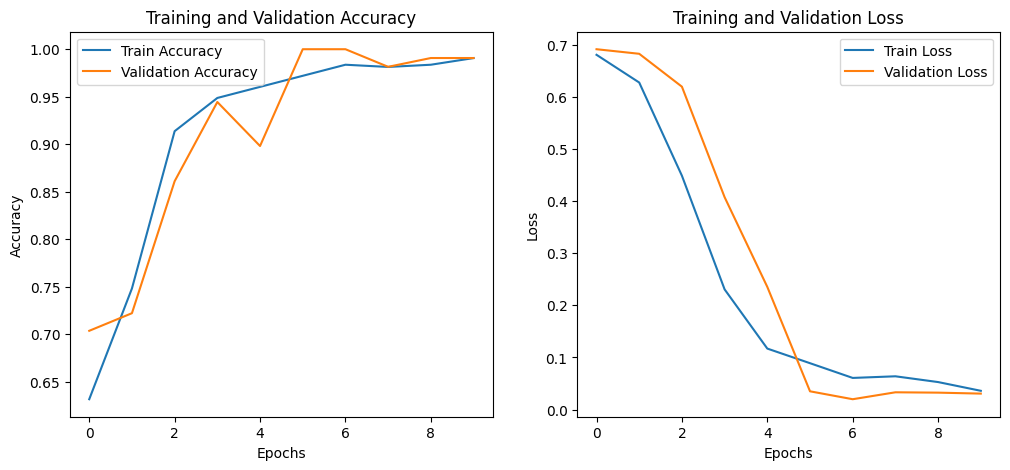

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Save the oversampled dataset to a CSV file
df_resampled = pd.DataFrame(X_resampled, columns=mfcc_mean_columns)
df_resampled["label"] = y_resampled

# Save to CSV
df_resampled.to_csv("oversampled_feature1.csv", index=False)

# Download the file in Colab
from google.colab import files
files.download("oversampled_feature1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>